1. data extraction(load, generation, day-ahead price) -> make function ☑️
  - 创造feature：
    - 风电太阳电预测误差（实际发电量-预测发电量）
    - 残差负荷（Residual Load）：总负荷 −（风电+光伏）
    - 可再生能源总占比： 可再生能源发电量 / 总发电量

2. 清洗intra day data
 - 去除夏令时冬令时转换的那几天 ☑️




In [1]:
import requests
from datetime import timedelta, datetime
import pandas as pd
import xml.etree.ElementTree as ET
import re
import numpy as np

In [ ]:
def entsoe_extract(url):
    payload = {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    if response.status_code == 200:
        root = ET.fromstring(response.content)
        m = re.match(r'\{(.*)\}', root.tag)
        namespace = m.group(1) if m else ' '
        ns = {'ns': namespace}

        data = []

        for timeseries in root.findall('.//ns:TimeSeries', ns):

            start = datetime.strptime(timeseries.find('.//ns:timeInterval/ns:start', ns).text, '%Y-%m-%dT%H:%MZ')
            resolution = timeseries.find('.//ns:resolution', ns).text
            delta = timedelta(minutes=15) if resolution == 'PT15M' else timedelta(hours=1)

            # 临时存储 point 数据，按 position 对齐
            point_dict = {}

            for point in timeseries.findall('.//ns:Point', ns):
                position = int(point.find('ns:position', ns).text)
                timestamp = start + (position - 1) * delta + timedelta(hours=1)

                for child in point:
                    tag = child.tag
                    if '}' in tag:
                        tag = tag.split('}')[1]
                    if tag != 'position':
                        value = float(child.text)
                        point_dict[position] = {'timestamp': timestamp, 'field': tag, 'value': value}

            # 找最大position，补全缺失
            max_pos = max(point_dict.keys())
            for pos in range(1, max_pos + 1):
                if pos in point_dict:
                    data.append(point_dict[pos])
                else:
                    timestamp = start + (pos - 1) * delta + timedelta(hours=1)
                    data.append({'timestamp': timestamp, 'field': tag, 'value': np.nan})

        df = pd.DataFrame(data)
    else:
        print(f'Failed to retrieve data: {response.status_code}')
        df = pd.DataFrame()

    return df

In [ ]:
def entsoe_extract_m(url):
    payload = {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    if response.status_code == 200:
        root = ET.fromstring(response.content)
        m = re.match(r'\{(.*)\}', root.tag)
        namespace = m.group(1) if m else ' '
        ns = {'ns': namespace}

        data = []

        for timeseries in root.findall('.//ns:TimeSeries', ns):
            mrid_text = timeseries.find('ns:mRID', ns).text
            if  mrid_text != '1':
              continue

            start = datetime.strptime(timeseries.find('.//ns:timeInterval/ns:start', ns).text, '%Y-%m-%dT%H:%MZ')
            resolution = timeseries.find('.//ns:resolution', ns).text
            delta = timedelta(minutes=15) if resolution == 'PT15M' else timedelta(hours=1)

            # 临时存储 point 数据，按 position 对齐
            point_dict = {}

            for point in timeseries.findall('.//ns:Point', ns):
                position = int(point.find('ns:position', ns).text)
                timestamp = start + (position - 1) * delta + timedelta(hours=1)

                for child in point:
                    tag = child.tag
                    if '}' in tag:
                        tag = tag.split('}')[1]
                    if tag != 'position':
                        value = float(child.text)
                        point_dict[position] = {'timestamp': timestamp, 'field': tag, 'value': value}

            # 找最大position，补全缺失
            max_pos = max(point_dict.keys())
            for pos in range(1, max_pos + 1):
                if pos in point_dict:
                    data.append(point_dict[pos])
                else:
                    timestamp = start + (pos - 1) * delta + timedelta(hours=1)
                    data.append({'timestamp': timestamp, 'field': tag, 'value': np.nan})

        df = pd.DataFrame(data)
    else:
        print(f'Failed to retrieve data: {response.status_code}')
        df = pd.DataFrame()

    return df

In [ ]:
# Day-ahead price
#day_ahead_price_url = f"https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A44&out_Domain=10Y1001A1001A82H&in_Domain=10Y1001A1001A82H&periodStart={P1Y_Start}&periodEnd={P1Y_End}&contract_MarketAgreement.type=A01&classificationSequence_AttributeInstanceComponent.position=2&offset=0"

# Load
actual_total_load_url = "https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A65&processType=A16&outBiddingZone_Domain=10Y1001A1001A82H&periodStart={start_date_str}&periodEnd={end_date_str}"
# start写的是2021-01-01 00:00 但不会自动从2020-12-31-23:00 开始，需要写早一个小时，但在网站上表示的是2021-01-01 00:00 - 00:15
day_ahead_total_load_forecast_url = "https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A65&processType=A01&outBiddingZone_Domain=10Y1001A1001A82H&periodStart={start_date_str}&periodEnd={end_date_str}"
# start写的是2021-01-01 00:00 但会自动从2020-12-31-23:00 开始，但在网站上表示的是2021-01-01 00:00 - 00:15

# Generation
actual_generation_solar_url = "https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A74&processType=A16&in_Domain=10Y1001A1001A82H&periodStart={start_date_str}&periodEnd={end_date_str}&PsrType=B16"
actual_generation_wind_offshore_url = "https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A74&processType=A16&in_Domain=10Y1001A1001A82H&periodStart={start_date_str}&periodEnd={end_date_str}&PsrType=B18"
actual_generation_wind_onshore_url = "https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A74&processType=A16&in_Domain=10Y1001A1001A82H&periodStart={start_date_str}&periodEnd={end_date_str}&PsrType=B19"
# 需要写早一个小时
day_ahead_generation_solar_forecasts_url = "https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A69&processType=A01&in_Domain=10Y1001A1001A82H&periodStart={start_date_str}&periodEnd={end_date_str}&PsrType=B16"
day_ahead_generation_wind_offshore_forecasts_url = "https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A69&processType=A01&in_Domain=10Y1001A1001A82H&periodStart={start_date_str}&periodEnd={end_date_str}&PsrType=B18"
day_ahead_generation_wind_onshore_url = "https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A69&processType=A01&in_Domain=10Y1001A1001A82H&periodStart={start_date_str}&periodEnd={end_date_str}&PsrType=B19"


In [ ]:
def fetch_entsoe_range_with_offset(start_date_str, end_date_str):
    """
    按 51 天时间段 & offset 分页循环请求 Entsoe API，并整合结果为 DataFrame
    """
    start_date = datetime.strptime(start_date_str, "%Y%m%d%H%M")
    end_date = datetime.strptime(end_date_str, "%Y%m%d%H%M")
    max_days = 51
    all_dfs = []

    while start_date < end_date:
        segment_end = min(start_date + timedelta(days=max_days), end_date)
        period_start_str = start_date.strftime("%Y%m%d%H%M")
        period_end_str = segment_end.strftime("%Y%m%d%H%M")

#        print(f"\nFetching segment: {period_start_str} to {period_end_str}")

        # offset 分页，每次 +100
        for offset in range(0, 4900, 100):
            url = f"https://web-api.tp.entsoe.eu/api?securityToken=f7d6cf51-b86d-4a1a-bab9-11ce4cd3fcb6&documentType=A44&out_Domain=10Y1001A1001A82H&in_Domain=10Y1001A1001A82H&periodStart={period_start_str}&periodEnd={period_end_str}&contract_MarketAgreement.type=A01&classificationSequence_AttributeInstanceComponent.position=2&offset={offset}"
            df = entsoe_extract(url)
            if df.empty:
    #            print(f"Offset {offset}: No more data, stopping.")
                break
  #          print(f"Offset {offset}: {len(df)} rows")
            all_dfs.append(df)

        start_date = segment_end  # 推进下一段时间

    day_ahead_price = pd.concat(all_dfs, ignore_index=True)
    day_ahead_price = day_ahead_price.drop_duplicates()
    return day_ahead_price

In [ ]:
def fetch_concat(start_date_str, end_date_str, url_t, func):
    all_dfs = []
    start_date = datetime.strptime(start_date_str, "%Y%m%d%H%M")
    end_date = datetime.strptime(end_date_str, "%Y%m%d%H%M")
    max_days = 365

    while start_date < end_date:
        segment_end = min(start_date + timedelta(days=max_days), end_date)
        period_start_str = start_date.strftime("%Y%m%d%H%M")
        period_end_str = segment_end.strftime("%Y%m%d%H%M")

        # 保持 url_template 不变，每次动态生成新 url
        url = url_t.format(start_date_str=period_start_str, end_date_str=period_end_str)

        print(f"Fetching: {period_start_str} → {period_end_str}")
        df = func(url)
        print(df.shape)
        all_dfs.append(df)

        start_date = segment_end


    data = pd.concat(all_dfs, ignore_index=True)
    data = data.drop_duplicates().reset_index(drop=True)
    print(data.shape)
    return data

In [ ]:
load_forecast = fetch_concat(
    start_date_str="202101070000",
    end_date_str="202312310000",
    url_t = day_ahead_total_load_forecast_url,
    func = entsoe_extract)

Fetching: 202101070000 → 202201070000
(35136, 3)
Fetching: 202201070000 → 202301070000
(34944, 3)
Fetching: 202301070000 → 202312310000
(34460, 3)
(104348, 3)


In [ ]:
day_ahead_price = fetch_entsoe_range_with_offset(
    start_date_str="202101070000",
    end_date_str="202312310000"
)
print(f"day_ahead_price: {day_ahead_price.shape}")

day_ahead_price: (104538, 3)


In [ ]:
generation_solar_forecast = fetch_concat(
    start_date_str="202101070000",
    end_date_str="202312310000",
    url_t = day_ahead_generation_solar_forecasts_url,
    func = entsoe_extract)

Fetching: 202101070000 → 202201070000
(35136, 3)
Fetching: 202201070000 → 202301070000
(35136, 3)
Fetching: 202301070000 → 202312310000
(34460, 3)
(104540, 3)


In [ ]:
generation_wind_onshore_forecast = fetch_concat(
    start_date_str="202101070000",
    end_date_str="202312310000",
    url_t = day_ahead_generation_wind_onshore_url,
    func = entsoe_extract)

Fetching: 202101070000 → 202201070000
(35136, 3)
Fetching: 202201070000 → 202301070000
(35136, 3)
Fetching: 202301070000 → 202312310000
(34460, 3)
(104540, 3)


In [ ]:
generation_wind_offshore_forecast = fetch_concat(
    start_date_str="202101070000",
    end_date_str="202312310000",
    url_t = day_ahead_generation_wind_offshore_forecasts_url,
    func = entsoe_extract)

Fetching: 202101070000 → 202201070000
(35136, 3)
Fetching: 202201070000 → 202301070000
(35136, 3)
Fetching: 202301070000 → 202312310000
(34464, 3)
(104544, 3)


In [ ]:
load_actual = fetch_concat(
    start_date_str="202101062300",
    end_date_str="202312310000",
    url_t = actual_total_load_url,
    func = entsoe_extract_m)

Fetching: 202101062300 → 202201062300
(35040, 3)
Fetching: 202201062300 → 202301062300
(35040, 3)
Fetching: 202301062300 → 202312310000
(34372, 3)
(104452, 3)


In [ ]:
generation_solar_actual = fetch_concat(
    start_date_str="202101062300",
    end_date_str="202312310000",
    url_t = actual_generation_solar_url,
    func = entsoe_extract_m)

Fetching: 202101062300 → 202201062300
(35040, 3)
Fetching: 202201062300 → 202301062300
(35040, 3)
Fetching: 202301062300 → 202312310000
(34372, 3)
(104452, 3)


In [ ]:
generation_wind_offshore_actual = fetch_concat(
    start_date_str="202101062300",
    end_date_str="202312310000",
    url_t = actual_generation_wind_offshore_url,
    func = entsoe_extract_m)

Fetching: 202101062300 → 202201062300
(35040, 3)
Fetching: 202201062300 → 202301062300
(35040, 3)
Fetching: 202301062300 → 202312310000
(34372, 3)
(104452, 3)


In [ ]:
generation_wind_onshore_actual = fetch_concat(
    start_date_str="202101062300",
    end_date_str="202312310000",
    url_t = actual_generation_wind_onshore_url,
    func = entsoe_extract_m)

Fetching: 202101062300 → 202201062300
(35040, 3)
Fetching: 202201062300 → 202301062300
(35040, 3)
Fetching: 202301062300 → 202312310000
(34372, 3)
(104452, 3)


In [ ]:
    """
    'generation_solar_actual': generation_solar_actual,
    'generation_wind_onshore_actual': generation_wind_onshore_actual,
    'generation_wind_offshore_actual': generation_wind_offshore_actual,
    'generation_wind_onshore_forecast': generation_wind_onshore_forecast,
    'generation_wind_offshore_forecast': generation_wind_offshore_forecast,
    'generation_solar_forecast': generation_solar_forecast
    """

In [ ]:
dfs = {
    'day_ahead_price': day_ahead_price,
    'load_forecast': load_forecast,
    'load_actual': load_actual,
    'generation_solar_actual': generation_solar_actual,
    'generation_wind_onshore_actual': generation_wind_onshore_actual,
    'generation_wind_offshore_actual': generation_wind_offshore_actual,
    'generation_wind_onshore_forecast': generation_wind_onshore_forecast,
    'generation_wind_offshore_forecast': generation_wind_offshore_forecast,
    'generation_solar_forecast': generation_solar_forecast

}

df_wide_list = []
for name, df in dfs.items():
    pivoted_df = df.pivot(index='timestamp', columns='field', values='value')

    pivoted_df.columns = [f"{name}" for col in pivoted_df.columns]
    df_wide_list.append(pivoted_df)


df_final = pd.concat(df_wide_list, axis=1).reset_index()


In [ ]:
df_final.isnull().sum()

,0
timestamp,0
day_ahead_price,557
load_forecast,196
load_actual,92
generation_solar_actual,92
generation_wind_onshore_actual,92
generation_wind_offshore_actual,92
generation_wind_onshore_forecast,4
generation_wind_offshore_forecast,0
generation_solar_forecast,4


In [ ]:
df_variables = df_final[(df_final['timestamp']<='2023-12-25 23:45:00') & (df_final['timestamp']>='2021-01-07 00:00:00') ].reset_index(drop=True)
dst_ranges = [
    (pd.Timestamp('2021-03-28 00:00:00'), pd.Timestamp('2021-10-30 23:59:59')),
    (pd.Timestamp('2022-03-27 00:00:00'), pd.Timestamp('2022-10-29 23:59:59')),
    (pd.Timestamp('2023-03-26 00:00:00'), pd.Timestamp('2023-10-28 23:59:59')),
]

mask = pd.Series(False, index=df_variables.index)
for start, end in dst_ranges:
    mask |= (df_variables['timestamp'] >= start) & (df_variables['timestamp'] <= end)

# 对这些行减去 1 小时
df_variables.loc[mask, 'timestamp'] = df_variables.loc[mask, 'timestamp'] + pd.Timedelta(hours=1)

df_variables['day_ahead_price'] = df_variables['day_ahead_price'].ffill()

df_variables['timestamp'] = pd.to_datetime(df_variables['timestamp'])

df_variables

,timestamp,day_ahead_price,load_forecast,load_actual,generation_solar_actual,generation_wind_onshore_actual,generation_wind_offshore_actual,generation_wind_onshore_forecast,generation_wind_offshore_forecast,generation_solar_forecast
0,2021-01-07 00:00:00,69.92,48553.0,54269.0,1.0,4682.0,1487.0,5660.0,1602.0,0.0
1,2021-01-07 00:15:00,53.12,47775.0,53619.0,1.0,4676.0,1379.0,5718.0,1570.0,0.0
2,2021-01-07 00:30:00,43.63,47348.0,52866.0,1.0,4734.0,1271.0,5774.0,1532.0,0.0
3,2021-01-07 00:45:00,35.64,47201.0,52446.0,1.0,4836.0,1202.0,5821.0,1498.0,0.0
4,2021-01-07 01:00:00,54.55,46576.0,51882.0,1.0,4870.0,1187.0,5862.0,1675.0,0.0
...,...,...,...,...,...,...,...,...,...,...
103963,2023-12-25 22:45:00,5.04,43088.0,43530.0,3.0,28958.0,6813.0,33823.0,5298.0,0.0
103964,2023-12-25 23:00:00,32.77,42401.0,43107.0,3.0,29217.0,6896.0,34167.0,5272.0,0.0
103965,2023-12-25 23:15:00,15.08,41926.0,42284.0,3.0,29826.0,6832.0,34548.0,5260.0,0.0
103966,2023-12-25 23:30:00,5.07,41316.0,41532.0,3.0,29831.0,6691.0,34919.0,5258.0,0.0


In [ ]:
df_variables.isnull().sum()

,0
timestamp,0
day_ahead_price,0
load_forecast,196
load_actual,0
generation_solar_actual,0
generation_wind_onshore_actual,0
generation_wind_offshore_actual,0
generation_wind_onshore_forecast,4
generation_wind_offshore_forecast,0
generation_solar_forecast,4


In [ ]:
df_variables['timestamp'] = pd.to_datetime(df_variables['timestamp'])

In [ ]:
df_variables.to_csv('external_variables.csv', index=False)

In [2]:

import pyarrow.parquet as pq
from datetime import datetime
import pytz

# 设置与 ExecutionTime 一致的时区
berlin = pytz.timezone('Europe/Berlin')

# 构造时区感知的 datetime 对象作为过滤条件
start = berlin.localize(datetime(2023, 1, 1))
end = berlin.localize(datetime(2024, 1, 1))

# 读取时过滤
table_2023 = pq.read_table(
    'TRAIN_Reco_2021_2022_2023.parquet.gzip',
    filters=[('ExecutionTime', '>=', start), ('ExecutionTime', '<', end)]
)

df = table_2023.to_pandas()

df = df[df['high'] != 0].reset_index() # 去除high为0的时候
#df = pd.read_parquet('TRAIN_Reco_2021_2022_2023.parquet.gzip', engine='pyarrow')


In [ ]:
df['weekday_num'] = pd.to_datetime(df['ExecutionTime']).dt.weekday
df['ID_weekday_num'] = df['ID'].str[:3]
df['ID_weekday_num'] = df['ID_weekday_num'].replace({
    'Mon': 0,
    'Tue': 1,
    'Wed': 2,
    'Thu': 3,
    'Fri': 4,
    'Sat': 5,
    'Sun': 6
})
df['days_to_add'] = (df['ID_weekday_num'] - df['weekday_num'])%7
df['delivery_date'] = df['ExecutionTime'].dt.date + pd.to_timedelta(df['days_to_add'], unit='d')

/tmp/ipython-input-3-540248251.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ID_weekday_num'] = df['ID_weekday_num'].replace({
/tmp/ipython-input-3-540248251.py:13: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  df['delivery_date'] = df['ExecutionTime'].dt.date + pd.to_timedelta(days_to_add, unit='d')


In [4]:
hours = df['ID'].str[3:5].astype(int)
minutes = ((df['ID'].str[-1].astype(int) - 1) * 15)
df['delivery_time'] = pd.to_datetime(df['delivery_date']) + pd.to_timedelta(hours, unit='h') + pd.to_timedelta(minutes, unit='m')
df

,ExecutionTime,ID,high,low,close,volume,weekday_num,ID_weekday_num,delivery_date,delivery_time
0,2023-01-05 15:30:00+01:00,Fri00Q1,133.43,97.22,133.43,0.050,3,4,2023-01-06,2023-01-06 00:00:00
1,2023-01-05 15:45:00+01:00,Fri00Q1,123.55,123.55,123.55,0.250,3,4,2023-01-06,2023-01-06 00:00:00
2,2023-01-05 16:00:00+01:00,Fri00Q1,133.43,133.43,133.43,0.100,3,4,2023-01-06,2023-01-06 00:00:00
3,2023-01-05 16:15:00+01:00,Fri00Q1,133.43,133.43,133.43,0.000,3,4,2023-01-06,2023-01-06 00:00:00
4,2023-01-05 16:30:00+01:00,Fri00Q1,133.43,133.43,133.43,0.000,3,4,2023-01-06,2023-01-06 00:00:00
...,...,...,...,...,...,...,...,...,...,...
2712760,2023-12-20 22:30:00+01:00,Wed23Q4,-3.80,-14.10,-3.80,107.825,2,2,2023-12-20,2023-12-20 23:45:00
2712761,2023-12-20 22:45:00+01:00,Wed23Q4,-3.80,-14.10,-3.80,0.000,2,2,2023-12-20,2023-12-20 23:45:00
2712762,2023-12-20 23:00:00+01:00,Wed23Q4,-3.80,-14.10,-3.80,0.000,2,2,2023-12-20,2023-12-20 23:45:00
2712763,2023-12-20 23:15:00+01:00,Wed23Q4,-3.80,-14.10,-3.80,0.000,2,2,2023-12-20,2023-12-20 23:45:00


In [5]:
df = df[['ExecutionTime', 'ID', 'high', 'low', 'close', 'volume','delivery_date', 'delivery_time']]
df.head()

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time
0,2023-01-05 15:30:00+01:00,Fri00Q1,133.43,97.22,133.43,0.05,2023-01-06,2023-01-06
1,2023-01-05 15:45:00+01:00,Fri00Q1,123.55,123.55,123.55,0.25,2023-01-06,2023-01-06
2,2023-01-05 16:00:00+01:00,Fri00Q1,133.43,133.43,133.43,0.10,2023-01-06,2023-01-06
3,2023-01-05 16:15:00+01:00,Fri00Q1,133.43,133.43,133.43,0.00,2023-01-06,2023-01-06
4,2023-01-05 16:30:00+01:00,Fri00Q1,133.43,133.43,133.43,0.00,2023-01-06,2023-01-06


In [6]:
df.to_parquet('train_2023.parquet',index=False)

In [2]:
import pandas as pd
df = pd.read_parquet('train_2023.parquet', engine='pyarrow')

## combine

In [117]:
df_variables = pd.read_csv('external_variables.csv')

In [ ]:
df_variables = df_variables[
    ~df_variables['timestamp'].isin([
        date(2021, 3, 28),
        date(2021, 11, 1),
        date(2022, 3, 27),
        date(2022, 10, 31),
        date(2023, 3, 26),
        date(2023, 10, 30),
    ])
].reset_index(drop=True)
df_variables.head()

,timestamp,day_ahead_price,load_forecast,load_actual,generation_solar_actual,generation_wind_onshore_actual,generation_wind_offshore_actual,generation_wind_onshore_forecast,generation_wind_offshore_forecast,generation_solar_forecast
0,2021-01-07 00:00:00,69.92,48553.0,54269.0,1.0,4682.0,1487.0,5660.0,1602.0,0.0
1,2021-01-07 00:15:00,53.12,47775.0,53619.0,1.0,4676.0,1379.0,5718.0,1570.0,0.0
2,2021-01-07 00:30:00,43.63,47348.0,52866.0,1.0,4734.0,1271.0,5774.0,1532.0,0.0
3,2021-01-07 00:45:00,35.64,47201.0,52446.0,1.0,4836.0,1202.0,5821.0,1498.0,0.0
4,2021-01-07 01:00:00,54.55,46576.0,51882.0,1.0,4870.0,1187.0,5862.0,1675.0,0.0


In [119]:
df_variables['timestamp'] = pd.to_datetime(df_variables['timestamp'])
df['delivery_time'] = pd.to_datetime(df['delivery_time'])

In [49]:
df.shape

(2712765, 8)

In [ ]:
df_variables.shape

(103968, 10)

In [135]:
df_combine = pd.merge(df, df_variables[['timestamp','day_ahead_price']], left_on='delivery_time', right_on='timestamp', how='left')
df_combine = df_combine.drop_duplicates(subset=['ExecutionTime', 'ID', 'delivery_time'], keep='first')
df_combine = df_combine.sort_values(by=['delivery_time','ExecutionTime']).reset_index(drop=True)
df_combine = df_combine.drop(columns=['timestamp'])
df_combine

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price
0,2023-01-01 00:00:00+01:00,Sun00Q2,2.01,-8.83,0.10,0.000,2023-01-01,2023-01-01 00:15:00,-29.95
1,2023-01-01 00:00:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00
2,2023-01-01 00:15:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00
3,2023-01-01 00:30:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00
4,2023-01-01 00:00:00+01:00,Sun01Q1,4.80,-5.51,-3.96,0.000,2023-01-01,2023-01-01 01:00:00,26.81
...,...,...,...,...,...,...,...,...,...
2712760,2023-12-24 21:45:00+01:00,Mon23Q4,-9.66,-11.84,-9.66,0.000,2023-12-25,2023-12-25 23:45:00,-4.93
2712761,2023-12-24 22:00:00+01:00,Mon23Q4,-9.65,-15.06,-15.06,2.825,2023-12-25,2023-12-25 23:45:00,-4.93
2712762,2023-12-24 22:15:00+01:00,Mon23Q4,-12.70,-12.80,-12.80,0.625,2023-12-25,2023-12-25 23:45:00,-4.93
2712763,2023-12-24 22:30:00+01:00,Mon23Q4,-2.74,-10.80,-8.66,3.350,2023-12-25,2023-12-25 23:45:00,-4.93


In [ ]:
# Add generation and load forecast and actual value based on delievry time
df_variables['generation_wind_forecast'] = df_variables['generation_wind_offshore_forecast'] + df_variables['generation_wind_onshore_forecast']
df_variables['generation_wind_actual'] = df_variables['generation_wind_offshore_actual'] + df_variables['generation_wind_onshore_actual']


forecast_cols = {
    'generation_wind_forecast': [
        (0, 0), (0, 15), (0, 30), (0, 45), (0, 60),
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'generation_solar_forecast': [
        (0, 0), (0, 15), (0, 30), (0, 45), (0, 60),
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'load_forecast': [
        (0, 0), (0, 15), (0, 30), (0, 45), (0, 60),
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'generation_wind_actual': [  
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'generation_solar_actual': [  
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ],
    'load_actual': [ 
        (1, 0), (1, 15), (1, 30), (1, 45), (1, 60)
    ]
}

df_result = df_combine[['delivery_time']].copy()

for var, offsets in forecast_cols.items():
    for days, minutes in offsets:
        prefix = var.replace('generation_', '').replace('_forecast', '').replace('_actual', '')
        label = f"{prefix}_{'actual' if 'actual' in var else 'forecast'}_t-{'1d-' if days==1 else ''}{minutes}m"

        ts = df_combine['delivery_time'] - pd.Timedelta(days=days, minutes=minutes)

        df_temp = pd.DataFrame({
            'delivery_time': df_combine['delivery_time'],
            'timestamp': ts
        })

        df_temp = df_temp.merge(
            df_variables[['timestamp', var]],
            on='timestamp',
            how='left'
        ).rename(columns={var: label})

        df_result[label] = df_temp[label]

df_result = df_result.sort_values(by='delivery_time').reset_index(drop=True)
df_result


,delivery_time,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,...,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m
0,2023-01-01 00:15:00,39347.0,38253.0,40736.0,38852.0,37958.0,36266.0,36607.0,40801.0,40976.0,...,6.0,6.0,4.0,3.0,4.0,40339.0,41471.0,42779.0,43577.0,44353.0
1,2023-01-01 00:45:00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,...,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0
2,2023-01-01 00:45:00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,...,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0
3,2023-01-01 00:45:00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,...,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0
4,2023-01-01 01:00:00,38927.0,39145.0,39266.0,39347.0,38253.0,35439.0,35881.0,36175.0,36266.0,...,5.0,5.0,5.0,6.0,6.0,38698.0,39002.0,39605.0,40339.0,41471.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712760,2023-12-25 23:45:00,38351.0,37840.0,37478.0,37090.0,36687.0,46549.0,47413.0,47461.0,47510.0,...,4.0,3.0,3.0,3.0,4.0,46319.0,45593.0,45833.0,46063.0,46291.0
2712761,2023-12-25 23:45:00,38351.0,37840.0,37478.0,37090.0,36687.0,46549.0,47413.0,47461.0,47510.0,...,4.0,3.0,3.0,3.0,4.0,46319.0,45593.0,45833.0,46063.0,46291.0
2712762,2023-12-25 23:45:00,38351.0,37909.0,37840.0,37478.0,37090.0,46452.0,46549.0,47413.0,47461.0,...,3.0,4.0,3.0,3.0,4.0,45870.0,46319.0,45593.0,45833.0,46291.0
2712763,2023-12-25 23:45:00,38351.0,37909.0,37840.0,37478.0,36687.0,46452.0,47413.0,47461.0,47510.0,...,3.0,3.0,3.0,3.0,4.0,45870.0,45593.0,45833.0,46063.0,46291.0


In [148]:
# Add the most recent actual value against the execution time
df_temp = df_combine.copy()
df_temp['timestamp'] = df_temp['ExecutionTime'] - pd.Timedelta(minutes=15)
df_temp['timestamp'] = df_temp['timestamp'].dt.tz_localize(None)
df_variables['timestamp'] = df_variables['timestamp'].dt.tz_localize(None)


# Step 2: 精确匹配 merge
df_temp = df_temp.merge(
    df_variables[['timestamp', 'generation_wind_actual', 'generation_solar_actual', 'load_actual']],
    on='timestamp',
    how='left'
).rename(columns={'generation_wind_actual': 'wind_actual_exc-15m', 'generation_solar_actual': 'solar_actual_exc-15m', 'load_actual': 'load_actual_exc-15m'})

df_temp = df_temp.drop_duplicates(subset=['ExecutionTime','delivery_time'],keep='first')
df_temp = df_temp.sort_values(by=['delivery_time', 'ExecutionTime']).reset_index(drop=True)
df_temp


,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,timestamp,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m
0,2023-01-01 00:00:00+01:00,Sun00Q2,2.01,-8.83,0.10,0.000,2023-01-01,2023-01-01 00:15:00,-29.95,2022-12-31 23:45:00,32602.0,3.0,40547.0
1,2023-01-01 00:00:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,2022-12-31 23:45:00,32602.0,3.0,40547.0
2,2023-01-01 00:15:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,2023-01-01 00:00:00,31623.0,2.0,39096.0
3,2023-01-01 00:30:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,2023-01-01 00:15:00,31912.0,2.0,38771.0
4,2023-01-01 00:00:00+01:00,Sun01Q1,4.80,-5.51,-3.96,0.000,2023-01-01,2023-01-01 01:00:00,26.81,2022-12-31 23:45:00,32602.0,3.0,40547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712760,2023-12-24 21:45:00+01:00,Mon23Q4,-9.66,-11.84,-9.66,0.000,2023-12-25,2023-12-25 23:45:00,-4.93,2023-12-24 21:30:00,42995.0,3.0,45833.0
2712761,2023-12-24 22:00:00+01:00,Mon23Q4,-9.65,-15.06,-15.06,2.825,2023-12-25,2023-12-25 23:45:00,-4.93,2023-12-24 21:45:00,42680.0,3.0,45593.0
2712762,2023-12-24 22:15:00+01:00,Mon23Q4,-12.70,-12.80,-12.80,0.625,2023-12-25,2023-12-25 23:45:00,-4.93,2023-12-24 22:00:00,42479.0,4.0,46319.0
2712763,2023-12-24 22:30:00+01:00,Mon23Q4,-2.74,-10.80,-8.66,3.350,2023-12-25,2023-12-25 23:45:00,-4.93,2023-12-24 22:15:00,43037.0,3.0,45870.0


In [151]:
df_final = pd.concat([df_combine, df_result, df_temp[['wind_actual_exc-15m', 'solar_actual_exc-15m', 'load_actual_exc-15m']]], axis=1)
df_final

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,delivery_time,...,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m
0,2023-01-01 00:00:00+01:00,Sun00Q2,2.01,-8.83,0.10,0.000,2023-01-01,2023-01-01 00:15:00,-29.95,2023-01-01 00:15:00,...,3.0,4.0,40339.0,41471.0,42779.0,43577.0,44353.0,32602.0,3.0,40547.0
1,2023-01-01 00:00:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,2023-01-01 00:45:00,...,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,32602.0,3.0,40547.0
2,2023-01-01 00:15:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,2023-01-01 00:45:00,...,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31623.0,2.0,39096.0
3,2023-01-01 00:30:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,2023-01-01 00:45:00,...,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31912.0,2.0,38771.0
4,2023-01-01 00:00:00+01:00,Sun01Q1,4.80,-5.51,-3.96,0.000,2023-01-01,2023-01-01 01:00:00,26.81,2023-01-01 01:00:00,...,6.0,6.0,38698.0,39002.0,39605.0,40339.0,41471.0,32602.0,3.0,40547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712760,2023-12-24 21:45:00+01:00,Mon23Q4,-9.66,-11.84,-9.66,0.000,2023-12-25,2023-12-25 23:45:00,-4.93,2023-12-25 23:45:00,...,3.0,4.0,46319.0,45593.0,45833.0,46063.0,46291.0,42995.0,3.0,45833.0
2712761,2023-12-24 22:00:00+01:00,Mon23Q4,-9.65,-15.06,-15.06,2.825,2023-12-25,2023-12-25 23:45:00,-4.93,2023-12-25 23:45:00,...,3.0,4.0,46319.0,45593.0,45833.0,46063.0,46291.0,42680.0,3.0,45593.0
2712762,2023-12-24 22:15:00+01:00,Mon23Q4,-12.70,-12.80,-12.80,0.625,2023-12-25,2023-12-25 23:45:00,-4.93,2023-12-25 23:45:00,...,3.0,4.0,45870.0,46319.0,45593.0,45833.0,46291.0,42479.0,4.0,46319.0
2712763,2023-12-24 22:30:00+01:00,Mon23Q4,-2.74,-10.80,-8.66,3.350,2023-12-25,2023-12-25 23:45:00,-4.93,2023-12-25 23:45:00,...,3.0,4.0,45870.0,45593.0,45833.0,46063.0,46291.0,43037.0,3.0,45870.0


In [152]:
df_final.columns

Index(['ExecutionTime', 'ID', 'high', 'low', 'close', 'volume',
       'delivery_date', 'delivery_time', 'day_ahead_price', 'delivery_time',
       'wind_forecast_t-0m', 'wind_forecast_t-15m', 'wind_forecast_t-30m',
       'wind_forecast_t-45m', 'wind_forecast_t-60m', 'wind_forecast_t-1d-0m',
       'wind_forecast_t-1d-15m', 'wind_forecast_t-1d-30m',
       'wind_forecast_t-1d-45m', 'wind_forecast_t-1d-60m',
       'solar_forecast_t-0m', 'solar_forecast_t-15m', 'solar_forecast_t-30m',
       'solar_forecast_t-45m', 'solar_forecast_t-60m',
       'solar_forecast_t-1d-0m', 'solar_forecast_t-1d-15m',
       'solar_forecast_t-1d-30m', 'solar_forecast_t-1d-45m',
       'solar_forecast_t-1d-60m', 'load_forecast_t-0m', 'load_forecast_t-15m',
       'load_forecast_t-30m', 'load_forecast_t-45m', 'load_forecast_t-60m',
       'load_forecast_t-1d-0m', 'load_forecast_t-1d-15m',
       'load_forecast_t-1d-30m', 'load_forecast_t-1d-45m',
       'load_forecast_t-1d-60m', 'wind_actual_t-1d-0m', 'wind_

In [154]:
pd.set_option('display.max_columns', None)
df_final.head()

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,delivery_time,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m
0,2023-01-01 00:00:00+01:00,Sun00Q2,2.01,-8.83,0.10,0.0,2023-01-01,2023-01-01 00:15:00,-29.95,2023-01-01 00:15:00,39347.0,38253.0,40736.0,38852.0,37958.0,36266.0,36607.0,40801.0,40976.0,41181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42577.0,43046.0,42898.0,43126.0,43490.0,42773.0,43998.0,45847.0,46418.0,46852.0,33370.0,33056.0,33439.0,34433.0,34958.0,6.0,6.0,4.0,3.0,4.0,40339.0,41471.0,42779.0,43577.0,44353.0,32602.0,3.0,40547.0
1,2023-01-01 00:00:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.0,2023-01-01,2023-01-01 00:45:00,-30.00,2023-01-01 00:45:00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,32602.0,3.0,40547.0
2,2023-01-01 00:15:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.0,2023-01-01,2023-01-01 00:45:00,-30.00,2023-01-01 00:45:00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31623.0,2.0,39096.0
3,2023-01-01 00:30:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.0,2023-01-01,2023-01-01 00:45:00,-30.00,2023-01-01 00:45:00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31912.0,2.0,38771.0
4,2023-01-01 00:00:00+01:00,Sun01Q1,4.80,-5.51,-3.96,0.0,2023-01-01,2023-01-01 01:00:00,26.81,2023-01-01 01:00:00,38927.0,39145.0,39266.0,39347.0,38253.0,35439.0,35881.0,36175.0,36266.0,36607.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40841.0,41302.0,41937.0,42577.0,43046.0,40371.0,42022.0,42256.0,42773.0,43998.0,32474.0,32426.0,33169.0,33370.0,33056.0,5.0,5.0,5.0,6.0,6.0,38698.0,39002.0,39605.0,40339.0,41471.0,32602.0,3.0,40547.0


In [161]:
df_final = df_final.loc[:, ~df_final.columns.duplicated()]
df_final.to_parquet('2023_train_energy_variables.parquet', index=False)

In [56]:
df_final = pd.read_parquet('2023_train_energy_variables.parquet', engine='pyarrow')

In [23]:
# missing value check
pd.set_option('display.max_columns', None)
df_final[df_final['load_forecast_t-1d-15m'].isnull()].delivery_date.value_counts()

delivery_date
2023-10-30    154
2023-03-27    150
Name: count, dtype: int64

In [59]:
# tamproal features
df_final['delivery_month_sin'] = np.sin(2 * np.pi * df_final['delivery_time'].dt.month / 12)
df_final['delivery_month_cos'] = np.cos(2 * np.pi * df_final['delivery_time'].dt.month / 12)

df_final['delivery_hour_sin'] = np.sin(2 * np.pi * df_final['delivery_time'].dt.hour / 24)
df_final['delivery_hour_cos'] = np.cos(2 * np.pi * df_final['delivery_time'].dt.hour / 24)

df_final['delivery_weekday_sin'] = np.sin(2 * np.pi * df_final['delivery_time'].dt.weekday / 7)
df_final['delivery_weekday_cos'] = np.cos(2 * np.pi * df_final['delivery_time'].dt.weekday / 7)

df_final['day_of_year_sin'] = np.sin(2 * np.pi * df_final['ExecutionTime'].dt.dayofyear / 365)
df_final['day_of_year_cos'] = np.cos(2 * np.pi * df_final['ExecutionTime'].dt.dayofyear / 365)


df_final['time_to_expiry_h'] = (df_final['delivery_time'] - df_final['ExecutionTime'].dt.tz_localize(None)).dt.total_seconds() / 3600

df_final['execution_quarter'] = df_final['ExecutionTime'].dt.quarter
df_final['execution_hour'] = df_final['ExecutionTime'].dt.hour

In [60]:
# exec quarter to hour difference
def add_quarter_hour_diff(df, value_col='close', delivery_col='delivery_time', quarter_col='execution_quarter', hour_col='execution_hour'):
    df_new = df.copy()

    df_new['quarter_avg'] = (
        df_new.groupby([delivery_col, quarter_col])[value_col].transform('mean')
    )

    df_new['hour_avg'] = (
        df_new.groupby([delivery_col, hour_col])[value_col].transform('mean')
    )

    df_new['quarter_to_hour_diff'] = df_new['quarter_avg'] - df_new['hour_avg']

    return df_new


df_final['quarter_avg'] = (
    df_final
    .groupby(['delivery_time', 'execution_quarter'])['close']
    .transform('mean')
)
df_final['hour_avg'] = (
    df_final
    .groupby(['delivery_time', 'execution_hour'])['close']
    .transform('mean')
)

df_final['quarter_to_hour_diff'] = df_final['quarter_avg'] - df_final['hour_avg']
df_final


,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m,delivery_month_sin,delivery_month_cos,delivery_hour_sin,delivery_hour_cos,delivery_weekday_sin,delivery_weekday_cos,day_of_year_sin,day_of_year_cos,time_to_expiry_h,execution_quarter,execution_hour,quarter_avg,hour_avg,quarter_to_hour_diff
0,2023-01-01 00:00:00+01:00,Sun00Q2,2.01,-8.83,0.10,0.000,2023-01-01,2023-01-01 00:15:00,-29.95,39347.0,38253.0,40736.0,38852.0,37958.0,36266.0,36607.0,40801.0,40976.0,41181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42577.0,43046.0,42898.0,43126.0,43490.0,42773.0,43998.0,45847.0,46418.0,46852.0,33370.0,33056.0,33439.0,34433.0,34958.0,6.0,6.0,4.0,3.0,4.0,40339.0,41471.0,42779.0,43577.0,44353.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.25,1,0,0.100000,0.100,0.000000
1,2023-01-01 00:00:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.75,1,0,-10.000000,-10.000,0.000000
2,2023-01-01 00:15:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31623.0,2.0,39096.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.50,1,0,-10.000000,-10.000,0.000000
3,2023-01-01 00:30:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31912.0,2.0,38771.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.25,1,0,-10.000000,-10.000,0.000000
4,2023-01-01 00:00:00+01:00,Sun01Q1,4.80,-5.51,-3.96,0.000,2023-01-01,2023-01-01 01:00:00,26.81,38927.0,39145.0,39266.0,39347.0,38253.0,35439.0,35881.0,36175.0,36266.0,36607.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40841.0,41302.0,41937.0,42577.0,43046.0,40371.0,42022.0,42256.0,42773.0,43998.0,32474.0,32426.0,33169.0,33370.0,33056.0,5.0,5.0,5.0,6.0,6.0,38698.0,39002.0,39605.0,40339.0,41471.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.258819,0.965926,-0.781831,0.62349,0.017213,0.999852,1.00,1,0,-3.960000,-3.960,0.00000

In [61]:
# treat each delivery date independently, apply normalization and asinh transformation
def transform_by_delivery_date(df, value_col='close', date_col='delivery_date', output_col=None):
    df_new = df.copy()
    if output_col is None:
        output_col = f'{value_col}_transformed'

    df_new[output_col] = np.nan
    norm_stats = {}

    for date, group in df_new.groupby(date_col):
        median = group[value_col].median()
        mad = (np.abs(group[value_col] - median)).median() / 0.674

        transformed = np.arcsinh((group[value_col] - median) / mad)

        df_new.loc[group.index, output_col] = transformed
        norm_stats[date] = {'median': median, 'mad': mad}

    return df_new

df_final = transform_by_delivery_date(df_final, value_col='close', date_col='delivery_date', output_col='close_transformed')


In [62]:
df_final

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m,delivery_month_sin,delivery_month_cos,delivery_hour_sin,delivery_hour_cos,delivery_weekday_sin,delivery_weekday_cos,day_of_year_sin,day_of_year_cos,time_to_expiry_h,execution_quarter,execution_hour,quarter_avg,hour_avg,quarter_to_hour_diff,close_transformed
0,2023-01-01 00:00:00+01:00,Sun00Q2,2.01,-8.83,0.10,0.000,2023-01-01,2023-01-01 00:15:00,-29.95,39347.0,38253.0,40736.0,38852.0,37958.0,36266.0,36607.0,40801.0,40976.0,41181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42577.0,43046.0,42898.0,43126.0,43490.0,42773.0,43998.0,45847.0,46418.0,46852.0,33370.0,33056.0,33439.0,34433.0,34958.0,6.0,6.0,4.0,3.0,4.0,40339.0,41471.0,42779.0,43577.0,44353.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.25,1,0,0.100000,0.100,0.000000,-0.607945
1,2023-01-01 00:00:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.75,1,0,-10.000000,-10.000,0.000000,-0.778554
2,2023-01-01 00:15:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31623.0,2.0,39096.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.50,1,0,-10.000000,-10.000,0.000000,-0.778554
3,2023-01-01 00:30:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31912.0,2.0,38771.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.25,1,0,-10.000000,-10.000,0.000000,-0.778554
4,2023-01-01 00:00:00+01:00,Sun01Q1,4.80,-5.51,-3.96,0.000,2023-01-01,2023-01-01 01:00:00,26.81,38927.0,39145.0,39266.0,39347.0,38253.0,35439.0,35881.0,36175.0,36266.0,36607.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40841.0,41302.0,41937.0,42577.0,43046.0,40371.0,42022.0,42256.0,42773.0,43998.0,32474.0,32426.0,33169.0,33370.0,33056.0,5.0,5.0,5.0,6.0,6.0,38698.0,39002.0,39605.0,40339.0,41471.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.258819,0.965926,-0.781831,0

In [67]:
df_final

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m,delivery_month_sin,delivery_month_cos,delivery_hour_sin,delivery_hour_cos,delivery_weekday_sin,delivery_weekday_cos,day_of_year_sin,day_of_year_cos,time_to_expiry_h,execution_quarter,execution_hour,quarter_avg,hour_avg,quarter_to_hour_diff,close_transformed
0,2023-01-01 00:00:00+01:00,Sun00Q2,2.01,-8.83,0.10,0.000,2023-01-01,2023-01-01 00:15:00,-29.95,39347.0,38253.0,40736.0,38852.0,37958.0,36266.0,36607.0,40801.0,40976.0,41181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42577.0,43046.0,42898.0,43126.0,43490.0,42773.0,43998.0,45847.0,46418.0,46852.0,33370.0,33056.0,33439.0,34433.0,34958.0,6.0,6.0,4.0,3.0,4.0,40339.0,41471.0,42779.0,43577.0,44353.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.25,1,0,0.100000,0.100,0.000000,-0.607945
1,2023-01-01 00:00:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.75,1,0,-10.000000,-10.000,0.000000,-0.778554
2,2023-01-01 00:15:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31623.0,2.0,39096.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.50,1,0,-10.000000,-10.000,0.000000,-0.778554
3,2023-01-01 00:30:00+01:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,31912.0,2.0,38771.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.25,1,0,-10.000000,-10.000,0.000000,-0.778554
4,2023-01-01 00:00:00+01:00,Sun01Q1,4.80,-5.51,-3.96,0.000,2023-01-01,2023-01-01 01:00:00,26.81,38927.0,39145.0,39266.0,39347.0,38253.0,35439.0,35881.0,36175.0,36266.0,36607.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40841.0,41302.0,41937.0,42577.0,43046.0,40371.0,42022.0,42256.0,42773.0,43998.0,32474.0,32426.0,33169.0,33370.0,33056.0,5.0,5.0,5.0,6.0,6.0,38698.0,39002.0,39605.0,40339.0,41471.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.258819,0.965926,-0.781831,0

In [99]:
#df_test = df_test[df_test['delivery_time']=='2023-01-02 01:00:00']
# 对于每个合同，如果是整点的合同，则从整点-1小时作为target variable，如果不是整点的合同，则向前取整点为target variable
df_test = df_final.copy()
df_test['ExecutionTime'] = df_test['ExecutionTime'].dt.tz_localize(None)
df_hourly = df_test[df_test['ExecutionTime'].dt.minute == 0].copy()
df_hourly['target_hour'] = df_hourly['ExecutionTime'].dt.floor('h')

In [100]:
df_hourly

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m,delivery_month_sin,delivery_month_cos,delivery_hour_sin,delivery_hour_cos,delivery_weekday_sin,delivery_weekday_cos,day_of_year_sin,day_of_year_cos,time_to_expiry_h,execution_quarter,execution_hour,quarter_avg,hour_avg,quarter_to_hour_diff,close_transformed,target_hour
0,2023-01-01 00:00:00,Sun00Q2,2.01,-8.83,0.10,0.000,2023-01-01,2023-01-01 00:15:00,-29.95,39347.0,38253.0,40736.0,38852.0,37958.0,36266.0,36607.0,40801.0,40976.0,41181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42577.0,43046.0,42898.0,43126.0,43490.0,42773.0,43998.0,45847.0,46418.0,46852.0,33370.0,33056.0,33439.0,34433.0,34958.0,6.0,6.0,4.0,3.0,4.0,40339.0,41471.0,42779.0,43577.0,44353.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.25,1,0,0.100000,0.1000,0.000000,-0.607945,2023-01-01 00:00:00
1,2023-01-01 00:00:00,Sun00Q4,-3.74,-14.39,-10.00,0.000,2023-01-01,2023-01-01 00:45:00,-30.00,39145.0,39266.0,39347.0,38253.0,40736.0,35881.0,36175.0,36266.0,36607.0,40801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41302.0,41937.0,42577.0,43046.0,42898.0,42022.0,42256.0,42773.0,43998.0,45847.0,32426.0,33169.0,33370.0,33056.0,33439.0,5.0,5.0,6.0,6.0,4.0,39002.0,39605.0,40339.0,41471.0,42779.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.000000,1.000000,-0.781831,0.62349,0.017213,0.999852,0.75,1,0,-10.000000,-10.0000,0.000000,-0.778554,2023-01-01 00:00:00
4,2023-01-01 00:00:00,Sun01Q1,4.80,-5.51,-3.96,0.000,2023-01-01,2023-01-01 01:00:00,26.81,38927.0,39145.0,39266.0,39347.0,38253.0,35439.0,35881.0,36175.0,36266.0,36607.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40841.0,41302.0,41937.0,42577.0,43046.0,40371.0,42022.0,42256.0,42773.0,43998.0,32474.0,32426.0,33169.0,33370.0,33056.0,5.0,5.0,5.0,6.0,6.0,38698.0,39002.0,39605.0,40339.0,41471.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.258819,0.965926,-0.781831,0.62349,0.017213,0.999852,1.00,1,0,-3.960000,-3.9600,0.000000,-0.678627,2023-01-01 00:00:00
8,2023-01-01 00:00:00,Sun01Q3,-4.80,-16.09,-5.31,48.400,2023-01-01,2023-01-01 01:30:00,-29.94,38760.0,38820.0,38927.0,39145.0,39266.0,34641.0,35136.0,35439.0,35881.0,36175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39746.0,40271.0,40841.0,41302.0,41937.0,39471.0,40149.0,40371.0,42022.0,42256.0,31800.0,32386.0,32474.0,32426.0,33169.0,5.0,5.0,5.0,5.0,5.0,37616.0,38182.0,38698.0,39002.0,39605.0,32602.0,3.0,40547.0,5.000000e-01,0.866025,0.258819,0.965926,-0.781831,0.62349,0.017213,0.999852,1.50,1,0,-5.476667,-5.4600,-0.016667,-0.701502,2023-01-01 00:00:00
12,2023-01-01 01:00:00,Sun01Q3,-0.60,-17.56,-5.51,0.000,2023-01-01,2023-01-01 01:30:00,-29.94,38760.0,38820.0,38927.0,39145.0,39266.0,34641.0,35136.0,35439.0,35881.0,36175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39746.0,40271.0,40841.0,41302.0,41937.0,39471.0,40149.0,40371.0,42022.0,42256.0,31800.0,32386.0,32474.0,32426.0,33169.0,5.0,5.0,5.0,5.0,5.0,37616.0,38182.0,38698.0,39002.0,39605.0,32044.0,

In [105]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712765 entries, 0 to 2712764
Data columns (total 72 columns):
 #   Column                   Dtype                        
---  ------                   -----                        
 0   ExecutionTime            datetime64[ns, Europe/Berlin]
 1   ID                       object                       
 2   high                     float64                      
 3   low                      float64                      
 4   close                    float64                      
 5   volume                   float64                      
 6   delivery_date            object                       
 7   delivery_time            datetime64[ns]               
 8   day_ahead_price          float64                      
 9   wind_forecast_t-0m       float64                      
 10  wind_forecast_t-15m      float64                      
 11  wind_forecast_t-30m      float64                      
 12  wind_forecast_t-45m      float64          

In [90]:
#delivery_time = df_test['delivery_time'].unique().str()
#end = (delivery_time - pd.Timedelta(minutes=15)).floor('h')
df_final[df_final['delivery_time'] == '2023-01-02 04:00:00']['ExecutionTime'].min().floor('h') 

Timestamp('2023-01-01 15:00:00+0100', tz='Europe/Berlin')

In [101]:
def extract_target_closes_from_group(delivery_time, group, df_hourly):
    # END 时间：delivery_time -15min，向下取整
    end = (delivery_time - pd.Timedelta(minutes=15)).floor('h')

    # START 时间：group 中 ExecutionTime 最早 + 3 小时
    start = group['ExecutionTime'].min().floor('h') + pd.Timedelta(hours=3)

    # 筛选在 [start, end] 区间的 close 值
    mask = (
        (df_hourly['delivery_time'] == delivery_time) &
        (df_hourly['target_hour'] >= start) &
        (df_hourly['target_hour'] <= end)
    )

    subset = df_hourly.loc[mask].copy()
    return subset


In [106]:
df_full = []

for delivery_time, group in df_test.groupby('delivery_time'):
    df_subset = extract_target_closes_from_group(delivery_time, group, df_hourly)
    df_full.append(df_subset)

df_targets = pd.concat(df_full, ignore_index=True)


In [112]:
df_targets

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m,delivery_month_sin,delivery_month_cos,delivery_hour_sin,delivery_hour_cos,delivery_weekday_sin,delivery_weekday_cos,day_of_year_sin,day_of_year_cos,time_to_expiry_h,execution_quarter,execution_hour,quarter_avg,hour_avg,quarter_to_hour_diff,close_transformed,target_hour
0,2023-01-01 03:00:00,Sun03Q2,-0.08,-28.17,-5.94,0.000,2023-01-01,2023-01-01 03:15:00,-29.93,37772.0,38397.0,38460.0,38513.0,38560.0,31733.0,32054.0,32443.0,32824.0,33181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37651.0,37631.0,38072.0,38451.0,38943.0,40001.0,39991.0,39870.0,39955.0,40100.0,28576.0,28454.0,29201.0,29699.0,30379.0,5.0,5.0,5.0,5.0,4.0,36932.0,36711.0,36612.0,37009.0,37179.0,33406.0,2.0,36932.0,5.000000e-01,0.866025,0.707107,0.707107,-0.781831,0.62349,0.017213,0.999852,0.25,1,3,-5.453077,-5.9400,0.486923,-0.712070,2023-01-01 03:00:00
1,2023-01-01 03:00:00,Sun03Q3,5.00,-17.10,-1.80,0.000,2023-01-01,2023-01-01 03:30:00,-29.94,37683.0,37772.0,38397.0,38460.0,38513.0,31372.0,31733.0,32054.0,32443.0,32824.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37558.0,37651.0,37631.0,38072.0,38451.0,40047.0,40001.0,39991.0,39870.0,39955.0,28642.0,28576.0,28454.0,29201.0,29699.0,5.0,5.0,5.0,5.0,5.0,36724.0,36932.0,36711.0,36612.0,37009.0,33406.0,2.0,36932.0,5.000000e-01,0.866025,0.707107,0.707107,-0.781831,0.62349,0.017213,0.999852,0.50,1,3,-5.448571,-1.8000,-3.648571,-0.641376,2023-01-01 03:00:00
2,2023-01-01 03:00:00,Sun04Q1,5.00,-9.00,-5.23,0.000,2023-01-01,2023-01-01 04:00:00,-29.90,37486.0,37585.0,37683.0,37772.0,38397.0,30664.0,31013.0,31372.0,31733.0,32054.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37771.0,37514.0,37558.0,37651.0,37631.0,40841.0,39970.0,40047.0,40001.0,39991.0,27881.0,28181.0,28642.0,28576.0,28454.0,5.0,5.0,5.0,5.0,5.0,36850.0,36693.0,36724.0,36932.0,36711.0,33406.0,2.0,36932.0,5.000000e-01,0.866025,0.866025,0.500000,-0.781831,0.62349,0.017213,0.999852,1.00,1,3,-5.306875,-5.2300,-0.076875,-0.700155,2023-01-01 03:00:00
3,2023-01-01 03:00:00,Sun04Q2,6.09,-15.99,-2.28,32.350,2023-01-01,2023-01-01 04:15:00,-29.93,37390.0,37486.0,37585.0,37683.0,37772.0,30489.0,30664.0,31013.0,31372.0,31733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37835.0,37771.0,37514.0,37558.0,37651.0,41048.0,40841.0,39970.0,40047.0,40001.0,28009.0,27881.0,28181.0,28642.0,28576.0,5.0,5.0,5.0,5.0,5.0,37122.0,36850.0,36693.0,36724.0,36932.0,33406.0,2.0,36932.0,5.000000e-01,0.866025,0.866025,0.500000,-0.781831,0.62349,0.017213,0.999852,1.25,1,3,-3.922000,-2.2800,-1.642000,-0.649723,2023-01-01 03:00:00
4,2023-01-01 04:00:00,Sun04Q2,6.09,-15.99,-2.28,0.000,2023-01-01,2023-01-01 04:15:00,-29.93,37390.0,37486.0,37585.0,37683.0,37772.0,30489.0,30664.0,31013.0,31372.0,31733.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37835.0,37771.0,37514.0,37558.0,37651.0,41048.0,40841.0,39970.0,40047.0,40001.0,28009.0,27881.0,28181.0,28642.0,28576.0,5.0,5.0,5.0,5.0,5.0,37122.0,36850.0,36693.0,36724.0,36932.0,30376.0

In [122]:
df_final.columns

Index(['ExecutionTime', 'ID', 'high', 'low', 'close', 'volume',
       'delivery_date', 'delivery_time', 'day_ahead_price',
       'wind_forecast_t-0m', 'wind_forecast_t-15m', 'wind_forecast_t-30m',
       'wind_forecast_t-45m', 'wind_forecast_t-60m', 'wind_forecast_t-1d-0m',
       'wind_forecast_t-1d-15m', 'wind_forecast_t-1d-30m',
       'wind_forecast_t-1d-45m', 'wind_forecast_t-1d-60m',
       'solar_forecast_t-0m', 'solar_forecast_t-15m', 'solar_forecast_t-30m',
       'solar_forecast_t-45m', 'solar_forecast_t-60m',
       'solar_forecast_t-1d-0m', 'solar_forecast_t-1d-15m',
       'solar_forecast_t-1d-30m', 'solar_forecast_t-1d-45m',
       'solar_forecast_t-1d-60m', 'load_forecast_t-0m', 'load_forecast_t-15m',
       'load_forecast_t-30m', 'load_forecast_t-45m', 'load_forecast_t-60m',
       'load_forecast_t-1d-0m', 'load_forecast_t-1d-15m',
       'load_forecast_t-1d-30m', 'load_forecast_t-1d-45m',
       'load_forecast_t-1d-60m', 'wind_actual_t-1d-0m', 'wind_actual_t-1d-15m',

# Make the data to wide format

In [134]:
# Define function to generate Lasso-ready features from a raw df
def generate_lasso_ready_df(df_raw, max_neighbors=3):
    import pandas as pd
    import numpy as np

    # Step 1: Preprocess
    df = df_raw.copy()
    df['ExecutionTime'] = pd.to_datetime(df['ExecutionTime']).dt.tz_localize(None)
    df['delivery_time'] = pd.to_datetime(df['delivery_time'])
    #df = df[['ExecutionTime', 'delivery_time', 'close', 'day_ahead_price']]
    df['execution_hour'] = df['ExecutionTime'].dt.floor('h')

    # Step 2: Compute execution hour ranges
    start_exec = df.groupby('delivery_time')['ExecutionTime'].min().dt.floor('h') + pd.Timedelta(hours=3)
    end_exec = df.groupby('delivery_time')['delivery_time'].first().apply(lambda x: (x - pd.Timedelta(minutes=15)).floor('h'))
    exec_range_df = pd.DataFrame({
        'delivery_time': start_exec.index,
        'start_hour': start_exec.values,
        'end_hour': end_exec.values
    })

    # Step 3: Construct target sample rows
    sample_rows = []
    for _, row in exec_range_df.iterrows():
        d_time, start, end = row['delivery_time'], row['start_hour'], row['end_hour']
        if end < start:
            continue
        for exec_hour in pd.date_range(start, end, freq='h'):
            sample_rows.append({'delivery_time': d_time, 'execution_hour': exec_hour})
    target_df = pd.DataFrame(sample_rows)

    # Step 4: Attach target close price
    hourly_close = df[df['ExecutionTime'].dt.minute == 0][['delivery_time', 'execution_hour', 'close']]
    hourly_close = hourly_close.rename(columns={'close': 'target_close'})
    target_df = target_df.merge(hourly_close, on=['delivery_time', 'execution_hour'], how='left')

    # Step 5: Preload quarter-level lookups
    df['quarter_hour'] = df['ExecutionTime']
    close_map = df.set_index(['delivery_time', 'quarter_hour'])['close'].to_dict()
    day_ahead_map = df.groupby('delivery_time')['day_ahead_price'].first().to_dict()
    df['delivery_hour'] = df['delivery_time'].dt.floor('h')
    delivery_to_neighbors = (
        df[['delivery_time', 'delivery_hour']]
        .drop_duplicates()
        .groupby('delivery_hour')['delivery_time']
        .apply(list)
        .to_dict()
    )

    static_forecast_cols = ['wind_forecast_t-0m', 'wind_forecast_t-15m', 'wind_forecast_t-30m',
       'wind_forecast_t-45m', 'wind_forecast_t-60m', 'wind_forecast_t-1d-0m',
       'wind_forecast_t-1d-15m', 'wind_forecast_t-1d-30m',
       'wind_forecast_t-1d-45m', 'wind_forecast_t-1d-60m',
       'solar_forecast_t-0m', 'solar_forecast_t-15m', 'solar_forecast_t-30m',
       'solar_forecast_t-45m', 'solar_forecast_t-60m',
       'solar_forecast_t-1d-0m', 'solar_forecast_t-1d-15m',
       'solar_forecast_t-1d-30m', 'solar_forecast_t-1d-45m',
       'solar_forecast_t-1d-60m', 'load_forecast_t-0m', 'load_forecast_t-15m',
       'load_forecast_t-30m', 'load_forecast_t-45m', 'load_forecast_t-60m',
       'load_forecast_t-1d-0m', 'load_forecast_t-1d-15m',
       'load_forecast_t-1d-30m', 'load_forecast_t-1d-45m',
       'load_forecast_t-1d-60m', 'wind_actual_t-1d-0m', 'wind_actual_t-1d-15m',
       'wind_actual_t-1d-30m', 'wind_actual_t-1d-45m', 'wind_actual_t-1d-60m',
       'solar_actual_t-1d-0m', 'solar_actual_t-1d-15m',
       'solar_actual_t-1d-30m', 'solar_actual_t-1d-45m',
       'solar_actual_t-1d-60m', 'load_actual_t-1d-0m', 'load_actual_t-1d-15m',
       'load_actual_t-1d-30m', 'load_actual_t-1d-45m', 'load_actual_t-1d-60m']
    
    forecast_maps = {
        col: df.groupby('delivery_time')[col].first().to_dict() for col in static_forecast_cols}
    
    actual_execu_cols = ['wind_actual_exc-15m', 'solar_actual_exc-15m', 'load_actual_exc-15m']

    actual_maps = {
        col: df.set_index(['delivery_time', 'ExecutionTime'])[col].to_dict() for col in actual_execu_cols}


    # Step 6: Feature extractor
    def extract_features(delivery_time, execution_hour):
        features = {}
        # current contract
        for i in range(12):
            t = execution_hour - pd.Timedelta(minutes=15 * (12 - i))
            features[f'tgt_close_t-{12 - i}'] = close_map.get((delivery_time, t), np.nan)
        
        for col in actual_execu_cols:
            features[f'{col}'] = actual_maps[col].get((delivery_time,execution_hour), np.nan)

        # neighbors
        d_hour = delivery_time.floor('h')
        neighbors = [d for d in delivery_to_neighbors.get(d_hour, []) if d != delivery_time]
        for j, neigh in enumerate(neighbors[:max_neighbors]):
            for i in range(12):
                t = execution_hour - pd.Timedelta(minutes=15 * (12 - i))
                features[f'neigh{j+1}_close_t-{12 - i}'] = close_map.get((neigh, t), np.nan)
        # static
        for col in static_forecast_cols:
            features[col] = forecast_maps[col].get(delivery_time, np.nan)
        features['day_ahead_price'] = day_ahead_map.get(delivery_time, np.nan)
        
        return features

    # Step 7: Apply
    all_feature_rows = []
    for row in target_df.itertuples():
        f_row = extract_features(row.delivery_time, row.execution_hour)
        f_row.update({
            'delivery_time': row.delivery_time,
            'execution_hour': row.execution_hour,
            'target_close': row.target_close
        })
        all_feature_rows.append(f_row)

    return pd.DataFrame(all_feature_rows)


In [ ]:
# Generate the lasso-ready dataframe
df_v1 = generate_lasso_ready_df(df_final)
df_v1


,tgt_close_t-12,tgt_close_t-11,tgt_close_t-10,tgt_close_t-9,tgt_close_t-8,tgt_close_t-7,tgt_close_t-6,tgt_close_t-5,tgt_close_t-4,tgt_close_t-3,tgt_close_t-2,tgt_close_t-1,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m,neigh1_close_t-12,neigh1_close_t-11,neigh1_close_t-10,neigh1_close_t-9,neigh1_close_t-8,neigh1_close_t-7,neigh1_close_t-6,neigh1_close_t-5,neigh1_close_t-4,neigh1_close_t-3,neigh1_close_t-2,neigh1_close_t-1,neigh2_close_t-12,neigh2_close_t-11,neigh2_close_t-10,neigh2_close_t-9,neigh2_close_t-8,neigh2_close_t-7,neigh2_close_t-6,neigh2_close_t-5,neigh2_close_t-4,neigh2_close_t-3,neigh2_close_t-2,neigh2_close_t-1,neigh3_close_t-12,neigh3_close_t-11,neigh3_close_t-10,neigh3_close_t-9,neigh3_close_t-8,neigh3_close_t-7,neigh3_close_t-6,neigh3_close_t-5,neigh3_close_t-4,neigh3_close_t-3,neigh3_close_t-2,neigh3_close_t-1,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,day_ahead_price,delivery_time,execution_hour,target_close
0,-4.99,-7.99,-4.70,-7.30,-3.38,-3.62,-4.27,-4.94,-5.94,-5.94,-5.94,-5.94,33406.0,2.0,36932.0,-8.70,-4.9,-6.22,-4.79,-6.76,-1.61,-5.1,0.12,0.12,0.12,0.12,0.12,-8.20,-7.21,-6.84,-9.00,-7.44,-4.48,-5.39,-12.72,-6.00,-1.80,-1.80,-1.80,-9.87,-9.89,-8.37,-3.71,-0.11,-2.91,-1.53,-13.66,-7.6,-8.4,NaN,NaN,37772.0,38397.0,38460.0,38513.0,38560.0,31733.0,32054.0,32443.0,32824.0,33181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37651.0,37631.0,38072.0,38451.0,38943.0,40001.0,39991.0,39870.0,39955.0,40100.0,28576.0,28454.0,29201.0,29699.0,30379.0,5.0,5.0,5.0,5.0,4.0,36932.0,36711.0,36612.0,37009.0,37179.0,-29.93,2023-01-01 03:15:00,2023-01-01 03:00:00,-5.94
1,-8.20,-7.21,-6.84,-9.00,-7.44,-4.48,-5.39,-12.72,-6.00,-1.80,-1.80,-1.80,33406.0,2.0,36932.0,-8.70,-4.9,-6.22,-4.79,-6.76,-1.61,-5.1,0.12,0.12,0.12,0.12,0.12,-4.99,-7.99,-4.70,-7.30,-3.38,-3.62,-4.27,-4.94,-5.94,-5.94,-5.94,-5.94,-9.87,-9.89,-8.37,-3.71,-0.11,-2.91,-1.53,-13.66,-7.6,-8.4,NaN,NaN,37683.0,37772.0,38397.0,38460.0,38513.0,31372.0,31733.0,32054.0,32443.0,32824.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37558.0,37651.0,37631.0,38072.0,38451.0,40047.0,40001.0,39991.0,39870.0,39955.0,28642.0,28576.0,28454.0,29201.0,29699.0,5.0,5.0,5.0,5.0,5.0,36724.0,36932.0,36711.0,36612.0,37009.0,-29.94,2023-01-01 03:30:00,2023-01-01 03:00:00,-1.80
2,-9.87,-9.89,-8.37,-3.71,-0.11,-2.91,-1.53,-13.66,-7.60,-8.40,NaN,NaN,NaN,NaN,NaN,-8.70,-4.9,-6.22,-4.79,-6.76,-1.61,-5.1,0.12,0.12,0.12,0.12,0.12,-4.99,-7.99,-4.70,-7.30,-3.38,-3.62,-4.27,-4.94,-5.94,-5.94,-5.94,-5.94,-8.20,-7.21,-6.84,-9.00,-7.44,-4.48,-5.39,-12.72,-6.0,-1.8,-1.8,-1.8,37585.0,37683.0,37772.0,38397.0,38460.0,31013.0,31372.0,31733.0,32054.0,32443.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37514.0,37558.0,37651.0,37631.0,38072.0,39970.0,40047.0,40001.0,39991.0,39870.0,28181.0,28642.0,28576.0,28454.0,29201.0,5.0,5.0,5.0,5.0,5.0,36693.0,36724.0,36932.0,36711.0,36612.0,-29.94,2023-01-01 03:45:00,2023-01-01 03:00:00,NaN
3,-5.00,-5.00,-1.64,-5.13,-2.00,-3.55,-5.40,-8.35,-7.20,-9.40,-6.09,-5.23,33406.0,2.0,36932.0,-3.64,-3.8,-3.99,-3.83,NaN,NaN,-5.6,-5.60,-7.30,-4.20,-4.30,-5.17,-5.00,-6.93,-4.03,

In [147]:
df_v1.to_parquet('df_wide_format.parquet',index=False)

In [ ]:
pd.set_option('display.max_rows', None)
df_v1[df_v1['target_close'].isnull()].delivery_time.value_counts()

delivery_time
2023-12-25 23:30:00    26
2023-12-25 23:45:00    25
2023-12-25 23:15:00    25
2023-12-25 23:00:00    24
2023-12-25 22:45:00    24
2023-12-25 22:30:00    24
2023-12-25 22:15:00    24
2023-12-25 22:00:00    23
2023-12-25 21:45:00    23
2023-12-25 21:30:00    23
2023-12-25 21:15:00    23
2023-12-25 20:45:00    22
2023-12-25 20:15:00    22
2023-12-25 20:30:00    22
2023-12-25 21:00:00    22
2023-12-25 20:00:00    21
2023-12-25 19:45:00    21
2023-12-25 19:30:00    21
2023-12-25 19:15:00    21
2023-12-25 19:00:00    20
2023-12-25 18:45:00    20
2023-12-25 18:30:00    20
2023-12-25 18:15:00    20
2023-12-25 18:00:00    19
2023-12-25 17:45:00    19
2023-12-25 17:30:00    19
2023-12-25 17:15:00    19
2023-12-25 16:45:00    18
2023-12-25 16:30:00    18
2023-12-25 16:15:00    18
2023-12-25 17:00:00    18
2023-12-25 16:00:00    17
2023-12-25 15:45:00    17
2023-12-25 15:30:00    17
2023-12-25 15:15:00    17
2023-12-25 13:30:00    17
2023-12-25 15:00:00    16
2023-12-25 14:45:00    1

In [138]:
df_final[df_final['delivery_time'] == '2023-12-25 23:45:00']

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m,delivery_month_sin,delivery_month_cos,delivery_hour_sin,delivery_hour_cos,delivery_weekday_sin,delivery_weekday_cos,day_of_year_sin,day_of_year_cos,time_to_expiry_h,execution_quarter,execution_hour,quarter_avg,hour_avg,quarter_to_hour_diff,close_transformed
2712741,2023-12-24 17:00:00+01:00,Mon23Q4,-17.49,-17.49,-17.49,0.250,2023-12-25,2023-12-25 23:45:00,-4.93,38351.0,37909.0,37840.0,37478.0,36687.0,46452.0,47413.0,47461.0,47510.0,47556.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44087.0,44398.0,44157.0,44368.0,45843.0,43789.0,45119.0,45133.0,45680.0,46111.0,43037.0,42680.0,42995.0,43322.0,43315.0,3.0,3.0,3.0,3.0,4.0,45870.0,45593.0,45833.0,46063.0,46291.0,46794.0,8.0,53271.0,-2.449294e-16,1.0,-0.258819,0.965926,0.0,1.0,-0.120208,0.992749,30.75,4,17,-11.687917,-15.2600,3.572083,-1.417659
2712742,2023-12-24 17:15:00+01:00,Mon23Q4,-15.06,-15.08,-15.06,0.650,2023-12-25,2023-12-25 23:45:00,-4.93,38351.0,37909.0,37840.0,37478.0,37090.0,46452.0,46549.0,47461.0,47510.0,47556.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44087.0,44398.0,44157.0,44368.0,45209.0,43789.0,44249.0,45133.0,45680.0,46111.0,43037.0,42479.0,42995.0,43322.0,43315.0,3.0,4.0,3.0,3.0,4.0,45870.0,46319.0,45833.0,46063.0,46291.0,46720.0,7.0,53531.0,-2.449294e-16,1.0,-0.258819,0.965926,0.0,1.0,-0.120208,0.992749,30.50,4,17,-11.687917,-15.2600,3.572083,-1.295055
2712743,2023-12-24 17:30:00+01:00,Mon23Q4,-15.00,-15.00,-15.00,0.375,2023-12-25,2023-12-25 23:45:00,-4.93,38351.0,37909.0,37840.0,37478.0,37090.0,46452.0,46549.0,47461.0,47510.0,47556.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44087.0,44398.0,44157.0,44368.0,45209.0,43789.0,44249.0,45133.0,45680.0,46111.0,43037.0,42479.0,42995.0,43322.0,43315.0,3.0,4.0,3.0,3.0,4.0,45870.0,46319.0,45833.0,46063.0,46291.0,46692.0,6.0,53747.0,-2.449294e-16,1.0,-0.258819,0.965926,0.0,1.0,-0.120208,0.992749,30.25,4,17,-11.687917,-15.2600,3.572083,-1.291856
2712744,2023-12-24 17:45:00+01:00,Mon23Q4,-13.49,-13.49,-13.49,0.075,2023-12-25,2023-12-25 23:45:00,-4.93,38351.0,37909.0,37840.0,37478.0,37090.0,46452.0,46549.0,47461.0,47510.0,47556.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44087.0,44398.0,44157.0,44368.0,45209.0,43789.0,44249.0,45133.0,45680.0,46111.0,43037.0,42479.0,42995.0,43322.0,43315.0,3.0,4.0,3.0,3.0,4.0,45870.0,46319.0,45833.0,46063.0,46291.0,46666.0,6.0,53899.0,-2.449294e-16,1.0,-0.258819,0.965926,0.0,1.0,-0.120208,0.992749,30.00,4,17,-11.687917,-15.2600,3.572083,-1.208331
2712745,2023-12-24 18:00:00+01:00,Mon23Q4,-10.56,-13.49,-10.56,0.450,2023-12-25,2023-12-25 23:45:00,-4.93,38351.0,37909.0,37840.0,37478.0,37090.0,46452.0,46549.0,47413.0,47510.0,47556.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44087.0,44398.0,44157.0,44368.0,45209.0,43789.0,44249.0,45119.0,45680.0,46111.0,43037.0,42479.0,42680.0,43322.0,43315.0,3.0,4.0,3.0,3.0,4.0,45870.0,46319.0,45593.0,46063.0,46291.0,46627.0,5.0,53614.0,-2.449294e-16,1.0,-0.258819,0.965926,0.0,1.0,

In [124]:
df_sample = df_final[df_final['delivery_time'] <= '2023-01-02 23:45:00']

In [136]:
df_lasso_ready_fn.to_csv('lasso_ready_data.csv', index=False)

In [116]:
df_targets[df_targets['delivery_time'] == '2023-01-02 23:45:00']

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m,delivery_month_sin,delivery_month_cos,delivery_hour_sin,delivery_hour_cos,delivery_weekday_sin,delivery_weekday_cos,day_of_year_sin,day_of_year_cos,time_to_expiry_h,execution_quarter,execution_hour,quarter_avg,hour_avg,quarter_to_hour_diff,close_transformed,target_hour
2571,2023-01-01 18:00:00,Mon23Q4,81.51,81.51,81.51,0.000,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,26501.0,3.0,49680.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017213,0.999852,29.75,1,18,92.6225,90.921250,1.701250,-1.399572,2023-01-01 18:00:00
2572,2023-01-01 19:00:00,Mon23Q4,82.00,82.00,82.00,0.000,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,25696.0,2.0,48796.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017213,0.999852,28.75,1,19,92.6225,90.922500,1.700000,-1.391198,2023-01-01 19:00:00
2573,2023-01-01 20:00:00,Mon23Q4,82.00,82.00,82.00,0.000,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,25215.0,2.0,47013.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017213,0.999852,27.75,1,20,92.6225,91.163750,1.458750,-1.391198,2023-01-01 20:00:00
2574,2023-01-01 21:00:00,Mon23Q4,82.00,82.00,82.00,0.000,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,25561.0,2.0,44157.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017213,0.999852,26.75,1,21,92.6225,91.297500,1.325000,-1.391198,2023-01-01 21:00:00
2575,2023-01-01 22:00:00,Mon23Q4,82.00,82.00,82.00,0.000,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,25120.0,2.0,43261.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017

In [121]:
df_final[df_final['delivery_time']=='2023-01-02 23:45:00'].head(30)

,ExecutionTime,ID,high,low,close,volume,delivery_date,delivery_time,day_ahead_price,wind_forecast_t-0m,wind_forecast_t-15m,wind_forecast_t-30m,wind_forecast_t-45m,wind_forecast_t-60m,wind_forecast_t-1d-0m,wind_forecast_t-1d-15m,wind_forecast_t-1d-30m,wind_forecast_t-1d-45m,wind_forecast_t-1d-60m,solar_forecast_t-0m,solar_forecast_t-15m,solar_forecast_t-30m,solar_forecast_t-45m,solar_forecast_t-60m,solar_forecast_t-1d-0m,solar_forecast_t-1d-15m,solar_forecast_t-1d-30m,solar_forecast_t-1d-45m,solar_forecast_t-1d-60m,load_forecast_t-0m,load_forecast_t-15m,load_forecast_t-30m,load_forecast_t-45m,load_forecast_t-60m,load_forecast_t-1d-0m,load_forecast_t-1d-15m,load_forecast_t-1d-30m,load_forecast_t-1d-45m,load_forecast_t-1d-60m,wind_actual_t-1d-0m,wind_actual_t-1d-15m,wind_actual_t-1d-30m,wind_actual_t-1d-45m,wind_actual_t-1d-60m,solar_actual_t-1d-0m,solar_actual_t-1d-15m,solar_actual_t-1d-30m,solar_actual_t-1d-45m,solar_actual_t-1d-60m,load_actual_t-1d-0m,load_actual_t-1d-15m,load_actual_t-1d-30m,load_actual_t-1d-45m,load_actual_t-1d-60m,wind_actual_exc-15m,solar_actual_exc-15m,load_actual_exc-15m,delivery_month_sin,delivery_month_cos,delivery_hour_sin,delivery_hour_cos,delivery_weekday_sin,delivery_weekday_cos,day_of_year_sin,day_of_year_cos,time_to_expiry_h,execution_quarter,execution_hour,quarter_avg,hour_avg,quarter_to_hour_diff,close_transformed
12139,2023-01-01 15:45:00+01:00,Mon23Q4,81.51,81.51,81.51,0.100,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,29223.0,1383.0,44158.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017213,0.999852,32.00,1,15,92.6225,99.028000,-6.405500,-1.399572
12140,2023-01-01 16:00:00+01:00,Mon23Q4,81.51,81.51,81.51,0.000,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,28900.0,764.0,44266.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017213,0.999852,31.75,1,16,92.6225,91.722500,0.900000,-1.399572
12141,2023-01-01 16:15:00+01:00,Mon23Q4,81.51,81.51,81.51,0.025,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,28365.0,324.0,45032.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017213,0.999852,31.50,1,16,92.6225,91.722500,0.900000,-1.399572
12142,2023-01-01 16:30:00+01:00,Mon23Q4,81.51,81.51,81.51,0.000,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,27868.0,84.0,45636.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017213,0.999852,31.25,1,16,92.6225,91.722500,0.900000,-1.399572
12143,2023-01-01 16:45:00+01:00,Mon23Q4,81.51,81.51,81.51,0.000,2023-01-02,2023-01-02 23:45:00,-30.0,23022.0,23298.0,23586.0,23871.0,24169.0,23193.0,22643.0,22666.0,22693.0,22756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51114.0,51738.0,52321.0,53013.0,53731.0,41276.0,42066.0,42587.0,43235.0,43840.0,22830.0,23126.0,23102.0,23154.0,23220.0,2.0,2.0,2.0,3.0,2.0,38249.0,38984.0,39846.0,40885.0,41553.0,27465.0,10.0,46355.0,0.5,0.866025,-0.258819,0.965926,0.0,1.0,0.017213,0.999852,31.00,1,16,92.6225,91.722500,0.900

In [66]:
df_final.columns

Index(['ExecutionTime', 'ID', 'high', 'low', 'close', 'volume',
       'delivery_date', 'delivery_time', 'day_ahead_price',
       'wind_forecast_t-0m', 'wind_forecast_t-15m', 'wind_forecast_t-30m',
       'wind_forecast_t-45m', 'wind_forecast_t-60m', 'wind_forecast_t-1d-0m',
       'wind_forecast_t-1d-15m', 'wind_forecast_t-1d-30m',
       'wind_forecast_t-1d-45m', 'wind_forecast_t-1d-60m',
       'solar_forecast_t-0m', 'solar_forecast_t-15m', 'solar_forecast_t-30m',
       'solar_forecast_t-45m', 'solar_forecast_t-60m',
       'solar_forecast_t-1d-0m', 'solar_forecast_t-1d-15m',
       'solar_forecast_t-1d-30m', 'solar_forecast_t-1d-45m',
       'solar_forecast_t-1d-60m', 'load_forecast_t-0m', 'load_forecast_t-15m',
       'load_forecast_t-30m', 'load_forecast_t-45m', 'load_forecast_t-60m',
       'load_forecast_t-1d-0m', 'load_forecast_t-1d-15m',
       'load_forecast_t-1d-30m', 'load_forecast_t-1d-45m',
       'load_forecast_t-1d-60m', 'wind_actual_t-1d-0m', 'wind_actual_t-1d-15m',

In [ ]:
# execution time group by hour, select the last one as the target variables
# 

<Axes: >

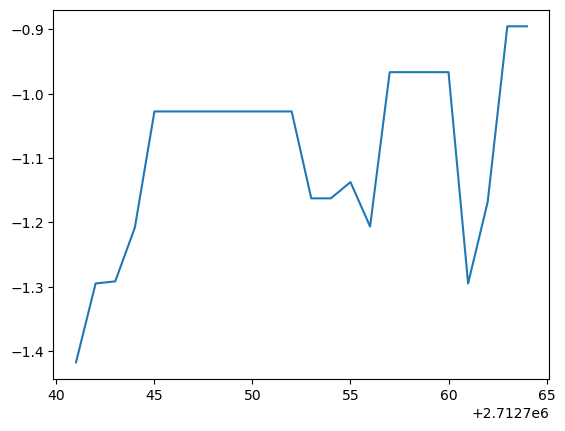

In [64]:
df_final[df_final['delivery_time'] == '2023-12-25 23:45:00']['close_transformed'].plot()

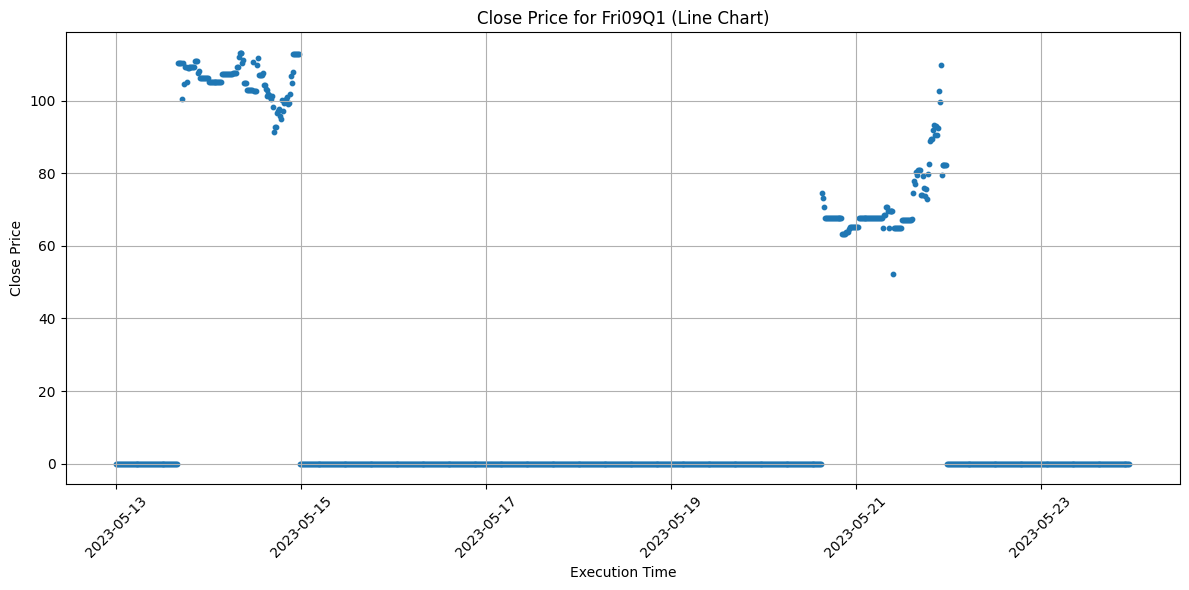

In [ ]:
import matplotlib.pyplot as plt

# Filter and sort
df_filtered = df[df['ID'] == 'Sun23Q4'].sort_index()
df_filtered = df_filtered[(df_filtered.index >= '2023-05-13 00:00') & (df_filtered.index <= '2023-05-23 23:00')]

# Plot using matplotlib directly
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered.index, df_filtered['close'], s=10)

# Format
plt.title('Close Price for Fri09Q1 (Line Chart)')
plt.xlabel('Execution Time')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
df_filtered[df_filtered['close']>0].iloc[110:128,:]

,ID,high,low,close,volume
ExecutionTime,,,,,
2023-05-14 19:30:00+02:00,Sun23Q4,99.45,98.83,99.45,1.350
2023-05-14 19:45:00+02:00,Sun23Q4,101.14,99.61,99.91,11.275
2023-05-14 20:00:00+02:00,Sun23Q4,101.60,99.47,100.40,9.200
2023-05-14 20:15:00+02:00,Sun23Q4,101.07,97.20,101.07,10.625
2023-05-14 20:30:00+02:00,Sun23Q4,101.38,98.80,99.18,2.825
2023-05-14 20:45:00+02:00,Sun23Q4,99.65,98.45,99.20,5.500
2023-05-14 21:00:00+02:00,Sun23Q4,101.79,98.69,101.79,15.825
2023-05-14 21:15:00+02:00,Sun23Q4,108.13,101.66,106.81,10.275
2023-05-14 21:30:00+02:00,Sun23Q4,111.20,104.49,104.86,22.050


In [ ]:
a[-1:-4:-1]

[4, 3, 2]